In [1]:
# --- NOTEBOOK 03: PREDICTIVE MODELING (Multi-Model) ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Metrics & Evaluation
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, average_precision_score, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler

# Konfigurasi Tampilan
pd.set_option('display.max_columns', 100)
plt.style.use('seaborn-v0_8')

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 1. LOAD DATA SIAP PAKAI
file_path = '../data/processed/master_data_modeled.csv'
df = pd.read_csv(file_path, parse_dates=['date'])

print(f"✅ Data Berhasil Dimuat: {len(df)} baris")
print("Kolom Tersedia:")
print(df.columns.tolist())
print(f"Rentang Data: {df['date'].min()} s.d {df['date'].max()}")

✅ Data Berhasil Dimuat: 1561206 baris
Kolom Tersedia:
['race_id', 'date', 'rank', 'horse_name', 'odds', 'popularity', 'horse_weight', 'distance', 'horse_no', 'frame_no', 'time_seconds', 'rotation_days', 'last_rank', 'last_3_avg_rank', 'race_count', 'race_seq_since_break', 'jockey_venue_win_rate', 'trainer_venue_win_rate', 'jockey_dist_cat_win_rate', 'horse_name_dist_cat_win_rate', 'horse_name_surface_win_rate', 'jockey_venue_surface_win_rate', 'venue_id', 'weather_id', 'surface_id', 'course_direction_id', 'race_class_id', 'sex_id', 'prev_running_style_id', 'dist_cat_id']
Rentang Data: 1986-01-05 00:00:00 s.d 2021-07-31 00:00:00


In [ ]:
# --- TAHAP 1: DEFINISI FITUR & TARGET ---
from sklearn.impute import SimpleImputer # Import Imputer

# 1. Buat Target
# Target 1: Win (Juara 1)
df['target_win'] = (df['rank'] == 1).astype(int)
# Target 2: Top 3 (Juara 1, 2, 3)
df['target_top3'] = (df['rank'] <= 3).astype(int)

# 2. Tentukan Fitur
# Pastikan membuang kolom string/objek yang tidak bisa di-scale
drop_cols = ['race_id', 'date', 'rank', 'target_win', 'target_top3', 'horse_no', 'horse_name','time_seconds'] 
# Catatan: Tambahkan kolom lain yang bukan angka jika masih error
features = [c for c in df.columns if c not in drop_cols and df[c].dtype in ['int64', 'float64', 'int32', 'float32']]

print(f"Jumlah Fitur: {len(features)}")

# --- TAHAP 2: SPLITTING DATA (TIME SERIES) ---
val_start_date = '2019-01-01' # Sesuaikan tanggal split Anda
test_start_date = '2020-01-01'

# Split Dataframes
train_df = df[df['date'] < val_start_date]
val_df = df[(df['date'] >= val_start_date) & (df['date'] < test_start_date)]
test_df = df[df['date'] >= test_start_date]

print(f"Data Train : {len(train_df)} baris")
print(f"Data Val   : {len(val_df)} baris")
print(f"Data Test  : {len(test_df)} baris")

# Siapkan X (Raw)
X_train = train_df[features].copy()
X_val = val_df[features].copy()
X_test = test_df[features].copy()

# --- STEP PENTING: IMPUTASI & SCALING UNTUK LOGISTIC/GNB ---
# 1. Imputasi (Isi NaN dengan rata-rata kolom)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=features)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=features)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=features)

# 2. Scaling (Standarisasi)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=features)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_imputed), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=features)

# Siapkan Target
targets = {
    'Win': {'train': train_df['target_win'], 'val': val_df['target_win'], 'test': test_df['target_win']},
    'Top3': {'train': train_df['target_top3'], 'val': val_df['target_top3'], 'test': test_df['target_top3']}
}

Jumlah Fitur: 25
Data Train : 1441935 baris
Data Val   : 45635 baris
Data Test  : 73636 baris


In [4]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, columns=['Pred 0', 'Pred 1'], index=['Actual 0', 'Actual 1'])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.show()

def plot_pr_auc(y_true, y_prob, title):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.3f}')
    plt.plot([0, 1], [y_true.mean(), y_true.mean()], linestyle='--', label='No Skill')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend()
    plt.show()
    return pr_auc

def run_model(model, model_name, X_tr, y_tr, X_v, y_v, X_te, y_te, is_tree=False):
    print(f"\n{'='*20} Training {model_name} {'='*20}")
    
    # Fit Model
    if is_tree and model_name in ['XGBoost', 'LightGBM', 'CatBoost']:
        # Menggunakan early stopping untuk Tree-based models
        eval_set = [(X_tr, y_tr), (X_v, y_v)]
        model.fit(X_tr, y_tr, eval_set=eval_set, verbose=False)
    else:
        model.fit(X_tr, y_tr)
        
    # Predict (Gunakan Data Test untuk Evaluasi Akhir)
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:, 1]
    
    # Metrics
    auc_score = roc_auc_score(y_te, y_prob)
    f1 = f1_score(y_te, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    print(f"ROC AUC   : {auc_score:.4f}")
    print(f"F1 Score  : {f1:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"Precision : {precision:.4f}")
    
    # Plots
    plot_confusion_matrix(y_te, y_pred, f'Confusion Matrix: {model_name}')
    pr_auc = plot_pr_auc(y_te, y_prob, f'PR Curve: {model_name}')
    
    return {
        'Model': model_name,
        'AUC': auc_score,
        'F1': f1,
        'Recall': recall,
        'Precision': precision,
        'PR_AUC': pr_auc
    }



################# TARGET: Win #################

==================== Training LogisticRegression (Win) ====================
ROC AUC   : 0.8430
F1 Score  : 0.2792
Recall    : 0.8573
Precision : 0.1668


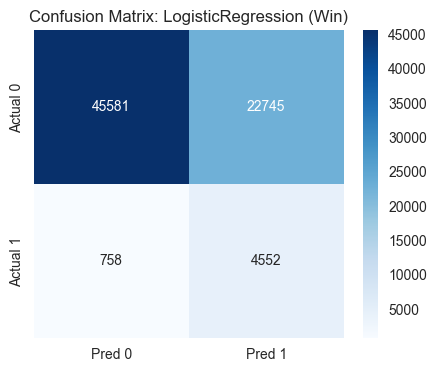

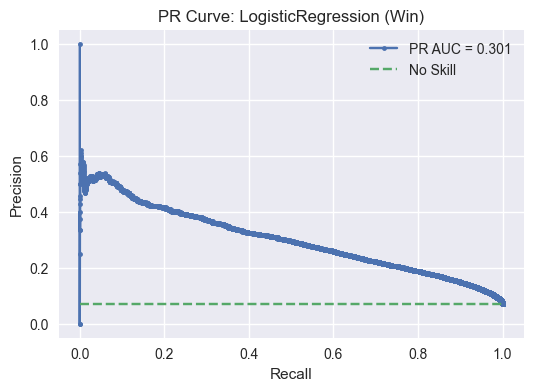

💾 Model tersimpan: trained_models/model_LogisticRegression_Win.pkl

==================== Training GaussianNB (Win) ====================
ROC AUC   : 0.7812
F1 Score  : 0.2762
Recall    : 0.5774
Precision : 0.1815


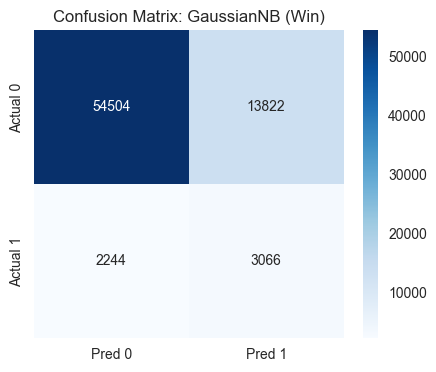

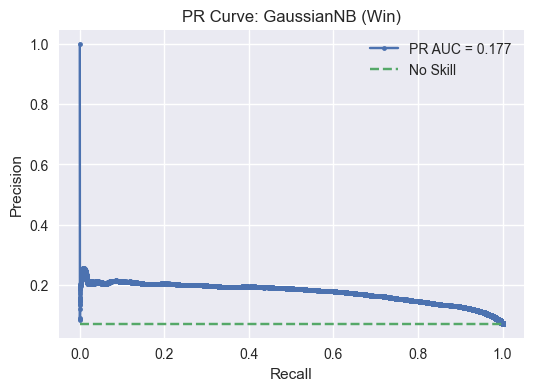

💾 Model tersimpan: trained_models/model_GaussianNB_Win.pkl

==================== Training XGBoost (Win) ====================
ROC AUC   : 0.8651
F1 Score  : 0.3243
Recall    : 0.8139
Precision : 0.2025


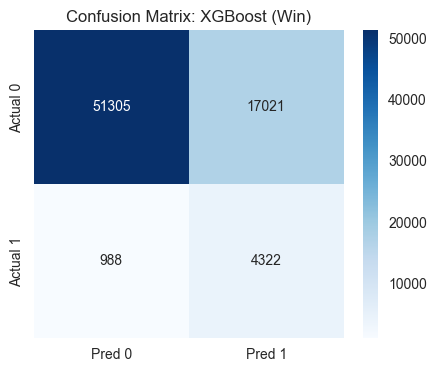

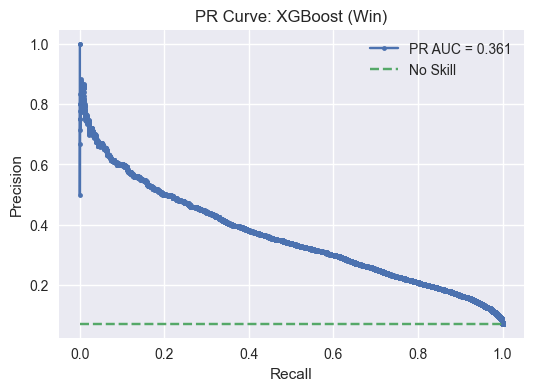

💾 Model tersimpan: trained_models/model_XGBoost_Win.pkl

==================== Training LightGBM (Win) ====================
ROC AUC   : 0.8638
F1 Score  : 0.3022
Recall    : 0.8565
Precision : 0.1835


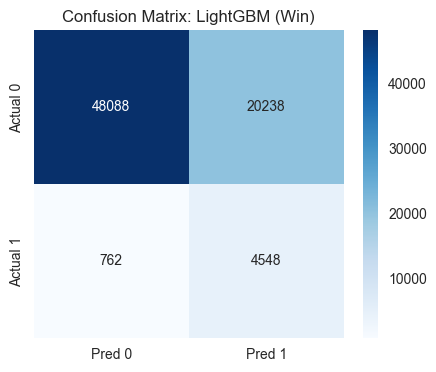

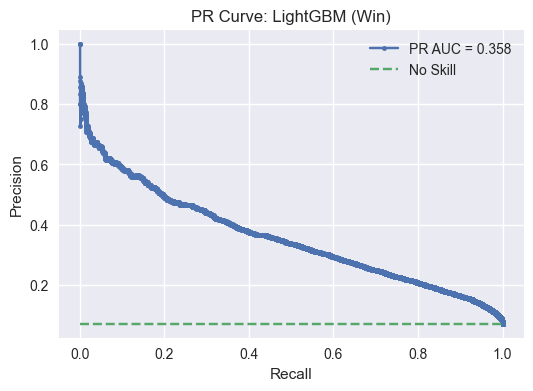

💾 Model tersimpan: trained_models/model_LightGBM_Win.pkl

==================== Training CatBoost (Win) ====================
ROC AUC   : 0.8582
F1 Score  : 0.3015
Recall    : 0.8418
Precision : 0.1836


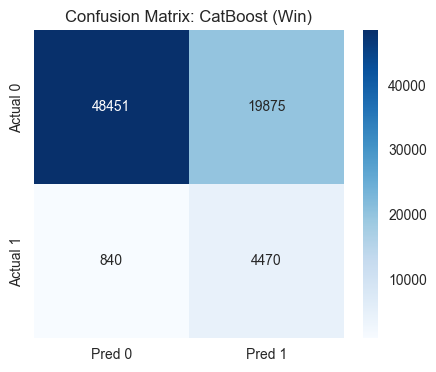

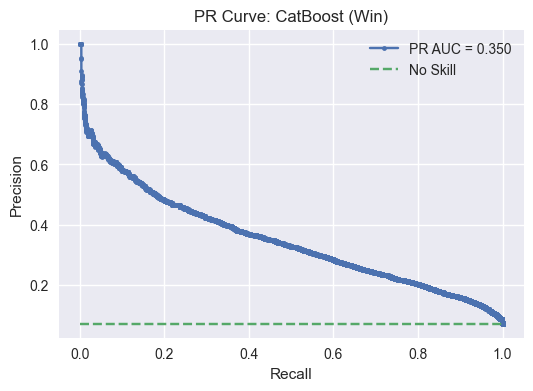

💾 Model tersimpan: trained_models/model_CatBoost_Win.pkl


################# TARGET: Top3 #################

==================== Training LogisticRegression (Top3) ====================
ROC AUC   : 0.8305
F1 Score  : 0.5442
Recall    : 0.8323
Precision : 0.4043


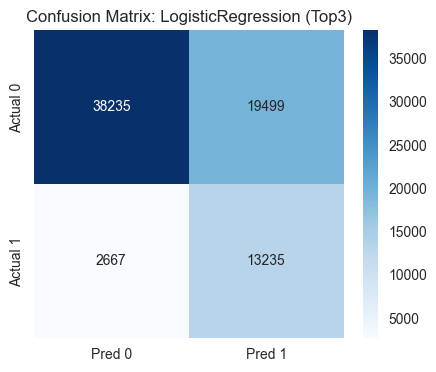

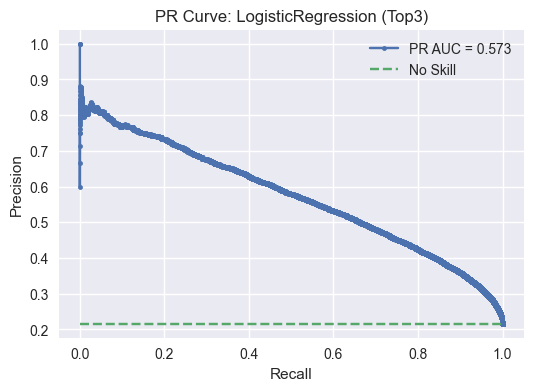

💾 Model tersimpan: trained_models/model_LogisticRegression_Top3.pkl

==================== Training GaussianNB (Top3) ====================
ROC AUC   : 0.7655
F1 Score  : 0.5038
Recall    : 0.6893
Precision : 0.3969


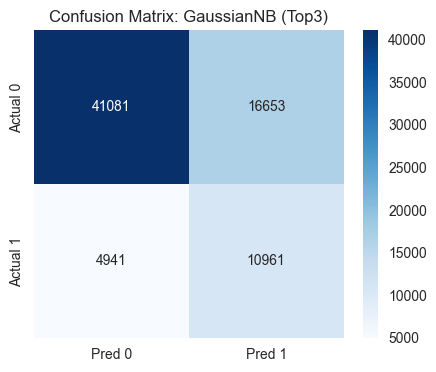

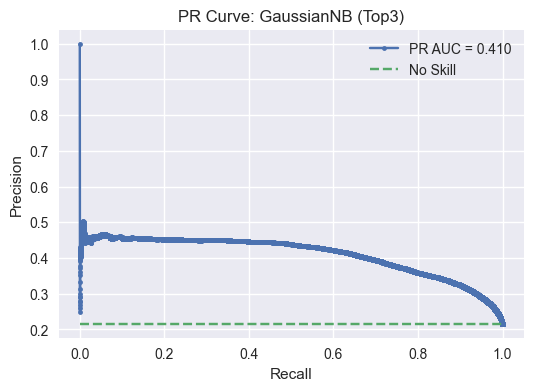

💾 Model tersimpan: trained_models/model_GaussianNB_Top3.pkl

==================== Training XGBoost (Top3) ====================
ROC AUC   : 0.8529
F1 Score  : 0.4887
Recall    : 0.9591
Precision : 0.3279


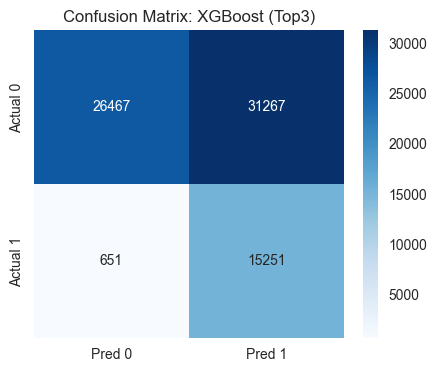

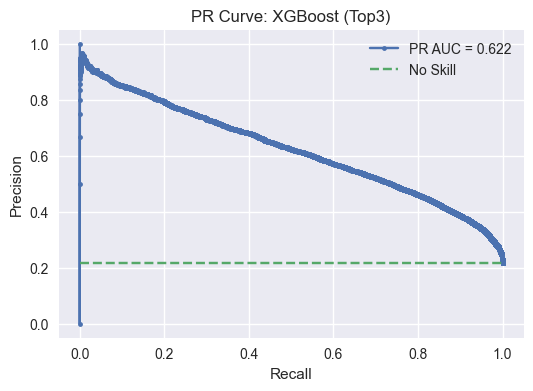

💾 Model tersimpan: trained_models/model_XGBoost_Top3.pkl

==================== Training LightGBM (Top3) ====================
ROC AUC   : 0.8525
F1 Score  : 0.5682
Recall    : 0.8443
Precision : 0.4282


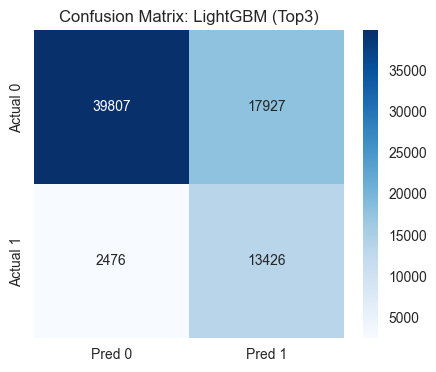

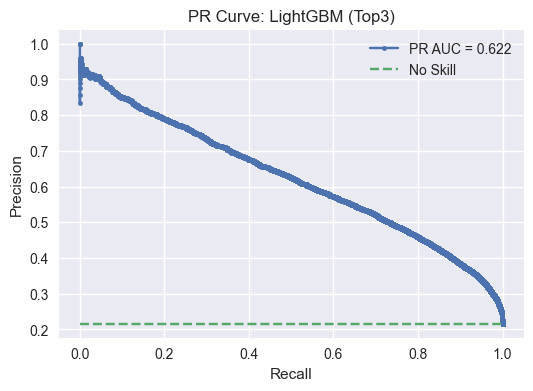

💾 Model tersimpan: trained_models/model_LightGBM_Top3.pkl

==================== Training CatBoost (Top3) ====================
ROC AUC   : 0.8433
F1 Score  : 0.5621
Recall    : 0.8215
Precision : 0.4272


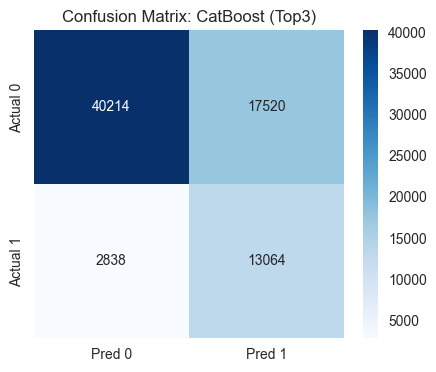

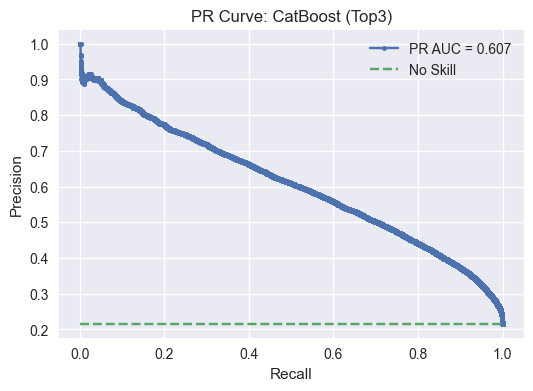

💾 Model tersimpan: trained_models/model_CatBoost_Top3.pkl

=== HASIL AKHIR ===


,Model,AUC,F1,Recall,Precision,PR_AUC
0,LogisticRegression (Win),0.842986,0.279204,0.857250,0.166758,0.301082
1,GaussianNB (Win),0.781245,0.276241,0.577401,0.181549,0.176807
2,XGBoost (Win),0.865112,0.324316,0.813936,0.202502,0.361007
3,LightGBM (Win),0.863791,0.302233,0.856497,0.183491,0.357616
4,CatBoost (Win),0.858179,0.301467,0.841808,0.183611,0.349745
5,LogisticRegression (Top3),0.830512,0.544247,0.832285,0.404320,0.573005
6,GaussianNB (Top3),0.765484,0.503769,0.689284,0.396936,0.409966
7,XGBoost (Top3),0.852938,0.488657,0.959062,0.327852,0.622010
8,LightGBM (Top3),0.852485,0.568236,0.844296,0.428221,0.621535
9,CatBoost (Top3),0.843331,0.562062,0.821532,0.427151,0.606971


In [5]:
import joblib
import os

# --- TAHAP 3: EKSEKUSI MODEL & SAVE ---

# 1. Buat folder untuk menyimpan model (jika belum ada)
save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Folder '{save_dir}' berhasil dibuat.")

# Inisialisasi Model (Sama seperti sebelumnya)
models = {
    'LogisticRegression': LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    'GaussianNB': GaussianNB(),
    'XGBoost': XGBClassifier(n_estimators=500, learning_rate=0.05, scale_pos_weight=10, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, class_weight='balanced', random_state=42, n_jobs=-1, verbose=-1),
    'CatBoost': CatBoostClassifier(iterations=500, learning_rate=0.05, auto_class_weights='Balanced', random_state=42, verbose=0)
}

results_log = []

for target_name, target_data in targets.items():
    print(f"\n\n################# TARGET: {target_name} #################")
    
    y_train_cur = target_data['train']
    y_val_cur = target_data['val']
    y_test_cur = target_data['test']
    
    for name, model in models.items():
        # Pilih data yang sesuai
        if name in ['LogisticRegression', 'GaussianNB']:
            X_tr_use = X_train_scaled
            X_v_use = X_val_scaled
            X_te_use = X_test_scaled
            is_tree = False
        else:
            X_tr_use = X_train
            X_v_use = X_val
            X_te_use = X_test
            is_tree = True
            
        try:
            # Training Model
            res = run_model(model, f"{name} ({target_name})", 
                            X_tr_use, y_train_cur, 
                            X_v_use, y_val_cur, 
                            X_te_use, y_test_cur, 
                            is_tree=is_tree)
            results_log.append(res)
            
            # --- BAGIAN BARU: SAVE MODEL ---
            # Nama file contoh: 'trained_models/model_XGBoost_Win.pkl'
            filename = f"{save_dir}/model_{name}_{target_name}.pkl"
            joblib.dump(model, filename)
            print(f"💾 Model tersimpan: {filename}")
            
        except Exception as e:
            print(f"ERROR pada model {name}: {str(e)}")

# Tampilkan Ringkasan Hasil
df_results = pd.DataFrame(results_log)
print("\n=== HASIL AKHIR ===")
display(df_results)